In [3]:
import sys
sys.path.append(r"C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages")
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

## Some boilerplate code for nicer looking confusion matrices


abridged from [scikit-learn example code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Some helper code to analyze TFIDF data

Credit for code goes to [buhrmann.github.io](https://buhrmann.github.io/tfidf-analysis.html)

In [5]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

# Load Data

In [6]:
# corpus_fpath = '../annotation_data/ldsi_w21_final_annotations_v1.json'
corpus_fpath = "../Data/ldsi_w2021-20220221T223611Z-001/ldsi_w2021/ldsi_w21_curated_annotations_v2.json"
data = json.load(open(corpus_fpath))

In [7]:
data.keys()

dict_keys(['documents', 'annotations', 'types'])

Define some convenience shorthands and dictionaries:

In [8]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

# Data Structures

Examine data structures so we know how to work with them

In [9]:
annotations[0]

{'_id': '61bb066d97ad59b4cfc4699a',
 'start': 15922,
 'end': 16078,
 'document': '61aea57397ad59b4cfc41399',
 'type': '61aeaf8097ad59b4cfc416d7'}

In [10]:
list(types_by_id.items())[0]

('61aeaf8097ad59b4cfc416d7',
 {'_id': '61aeaf8097ad59b4cfc416d7',
  'name': 'CaseFooter',
  'isA': '58781cf945f90f3bfc5cba7d',
  'attributes': []})

In [11]:
list(documents_by_id.items())[0]

('61aea55c97ad59b4cfc4128c',
 {'_id': '61aea55c97ad59b4cfc4128c',
  'name': '0601461.txt',
  'plainText': 'Citation Nr: 0601461\t\r\nDecision Date: 01/18/06    Archive Date: 01/31/06\r\n\r\nDOCKET NO.  04-17 231\t)\tDATE\r\n\t)\r\n\t)\r\n\r\nOn appeal from the\r\nDepartment of Veterans Affairs Regional Office in No. Little \r\nRock, Arkansas\r\n\r\n\r\nTHE ISSUE\r\n\r\nEntitlement to service connection for hepatitis C.\r\n\r\n\r\nREPRESENTATION\r\n\r\nAppellant represented by:\tThe American Legion\r\n\r\n\r\nWITNESS AT HEARING ON APPEAL\r\n\r\nAppellant\r\n\r\n\r\nATTORNEY FOR THE BOARD\r\n\r\nP. Olson, Associate Counsel\r\n\r\n\r\nINTRODUCTION\r\n\r\nThe veteran had active military service from May 1971 to July \r\n1976.\r\n\r\nThis matter comes before the Board of Veterans\' Appeals \r\n(Board or BVA) on appeal from a July 2003 rating decision of \r\nthe Department of Veterans Affairs (VA) Regional Office (RO) \r\nin N. Little Rock, Arkansas.\r\n\r\nIn August 2004, the veteran testif

# Very Basic Data Survey

In [12]:
len(documents_by_id)

540

In [13]:
len(annotations)

15349

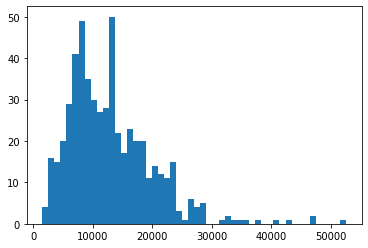

In [14]:
doc_lengths = [len(d['plainText']) for d in documents_by_id.values()]
plt.hist(doc_lengths, bins=50)
plt.show()

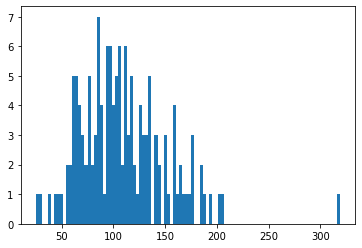

In [15]:
doc_num_annos = [len([a for a in annotations if a['document'] == doc_id])
                 for doc_id in documents_by_id]
doc_num_annos = [n for n in doc_num_annos if n > 0]
plt.hist(doc_num_annos, bins=100)
plt.show()

# Create Corpus

In [16]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              'end': a['end']}
        span_data.append(sd)
    return span_data

In [17]:
spans = make_span_data(documents_by_id, types_by_id, annotations)
span_labels = [s['type'] for s in spans]

In [18]:
spans[0]

{'txt': "____________________________________________\r\nDEBORAH W. SINGLETON\r\nVeterans Law Judge, Board of Veterans' Appeals\r\n\r\n\r\n\r\n\r\n Department of Veterans Affairs\r",
 'document': '61aea57397ad59b4cfc41399',
 'type': 'CaseFooter',
 'start': 15922,
 'start_normalized': 0.9899894298327426,
 'end': 16078}

Sample train and test set while stratifying across types

In [19]:
train_spans, test_spans = model_selection.train_test_split(spans,
                                                           test_size=.2,
                                                           random_state=42,
                                                           stratify=span_labels)
train_spans_txt = [s['txt'] for s in train_spans]
test_spans_txt = [s['txt'] for s in test_spans]

In [20]:
print(len(train_spans))
print(len(test_spans))

12279
3070


In [21]:
train_spans[0]

{'txt': 'Eddy v. Brown, 9 \r\nVet. App. 52 (1996). ',
 'document': '61aea57097ad59b4cfc4135b',
 'type': 'Citation',
 'start': 6722,
 'start_normalized': 0.6137131379530723,
 'end': 6762}

In [22]:
train_spans_txt[0]

'Eddy v. Brown, 9 \r\nVet. App. 52 (1996). '

In [23]:
print(f'train: {len(train_spans)}; test: {len(test_spans)}')

train: 12279; test: 3070


In [24]:
random.choice(train_spans)

{'txt': 'Citation Nr: 1014839\t\r\nDecision Date: 04/19/10    Archive Date: 04/30/10\r\n\r\nDOCKET NO.  07-00 723\t)\tDATE\r\n\t)\r\n\t)\r',
 'document': '61aea55d97ad59b4cfc412bc',
 'type': 'CaseHeader',
 'start': 0,
 'start_normalized': 0.0,
 'end': 113}

# Some Tough Examples

In [25]:
example_basic_1 = 'In sum, as the preponderance of the evidence is against the Veteran\'s claim, his appeal must be denied.'
example_cit_1 = 'Smith v. Gober, 14 Vet. App. 227 (2000), aff\'d 281 F.3d 1384 (Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).'
example_rule_1 = '"To establish a right to compensation for a present disability, a Veteran must show: "(1) the existence of a present disability; (2) in-service incurrence or aggravation of a disease or injury; and (3) a causal relationship between the present disability and the disease or injury incurred or aggravated during service"-the so-called "nexus" requirement."'
example_mixed_1 = 'In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded. '

# Manual Tokenization Example

In [26]:
def tokenize(txt):
    dirty_tokens = re.split(' +', txt)  # split words
    # remove all non-alphanumerics
    clean_tokens = [re.sub(r'\W', '', t).lower() 
                    for t in dirty_tokens]
    if '' in clean_tokens:  # remove empty tokens
        clean_tokens.remove('')
    return clean_tokens


def tokenize_spans(spans):
    for s in spans:
        s['tokens_manual'] = tokenize(s['txt'])
        
        
def build_vocabulary(spans):
    vocab_counts = {}
    for sd in spans:
        for t in tokenize(sd['txt']):
            if t in vocab_counts:
                vocab_counts[t] += 1
            else:
                vocab_counts[t] = 1
    return vocab_counts

We can use this basic tokenizer to do some surface statistics

In [27]:
tokenize(example_cit_1)

['smith',
 'v',
 'gober',
 '14',
 'vet',
 'app',
 '227',
 '2000',
 'affd',
 '281',
 'f3d',
 '1384',
 'fed',
 'cir',
 '2002',
 'dela',
 'cruz',
 'v',
 'principi',
 '15',
 'vet',
 'app',
 '143',
 '2001',
 'see',
 'also',
 'quartuccio',
 'v',
 'principi',
 '16',
 'vet',
 'app',
 '183',
 '2002']

In [28]:
tokenize_spans(train_spans)

In [29]:
vocab_counts_manual = build_vocabulary(train_spans)
unique_tokens_manual = [token for token, count in vocab_counts_manual.items() 
                        if count == 1]

In [33]:
unique_tokens_manual

['eddy',
 'hertzhertz5001000200030004000right5580115115nrleft6585110nrnr',
 'rifles',
 'generators',
 '19751996',
 '1349',
 'dissimilar',
 'herpetiformis',
 'shortlasting',
 'miercort',
 'campbell',
 'hubenette',
 'scharfen',
 '1506830decision',
 '021315',
 '021815docket',
 '1306',
 'epa',
 'carcinogen',
 'draft',
 'reassessment',
 'admiral',
 'zumwalt',
 'smoke',
 'papilloma',
 'carcinogenic',
 'estimated',
 '12056',
 'gtf',
 'commander',
 'boundary',
 'counter',
 'infiltration',
 'utilizes',
 'stone',
 'waivered',
 'insoles',
 'salkos',
 'incompetent',
 'grass',
 'holder',
 'declines',
 'asks',
 'remissions',
 'nactive',
 'nearsightedness',
 'diesel',
 'fuels',
 'malleoulus',
 'otitis',
 'media',
 'seated',
 'bephysical',
 'staminaupper',
 'extremitieslowerextremitieshearing',
 'earseyespsychiatric',
 'condition111111',
 'parakkalacting',
 'concomitantly',
 'emitting',
 'fitted',
 'cumbersome',
 '147',
 'youth',
 'surprising',
 'waited',
 'unbearable',
 'mentioning',
 'erected',
 'ta

In [34]:
print(len(vocab_counts_manual))
print(vocab_counts_manual['veteran'])
print(len(unique_tokens_manual))

9163
2887
3767


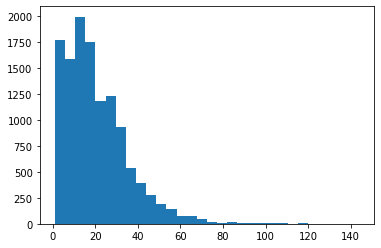

In [35]:
span_lengths_manual = [len(s['tokens_manual']) for s in train_spans]
plt.hist(span_lengths_manual, bins=30)
plt.show()

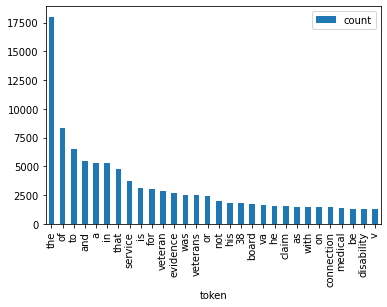

In [36]:
vocab_df = pd.DataFrame([{'token': t, 'count': c} for t, c in vocab_counts_manual.items()])
vocab_df = vocab_df.set_index(['token'])
vocab_df.sort_values('count', ascending=False)[:30].plot.bar()
plt.show()

In [37]:
min_freq = 6
max_freq = 100
feature_names_manual = sorted(token for token, count in vocab_counts_manual.items() 
                       if min_freq <= count <= max_freq)
print(f'number of thresholded with {min_freq} < n < {max_freq}: {len(feature_names_manual)}')

number of thresholded with 6 < n < 100: 2340


# Basic TFIDF vectorization with sklearn

We are using sklear's [TFIDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit) here, because it is faster than doing it all by ourselves and has useful default parameters

In [84]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer = vectorizer.fit(train_spans_txt)
tfidf_features_skl = vectorizer.get_feature_names()
len(tfidf_features_skl)

C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2924

In [44]:
vectorizer.transform(train_spans_txt).toarray().shape

(12279, 2924)

In [45]:
train_spans

[{'txt': 'Eddy v. Brown, 9 \r\nVet. App. 52 (1996). ',
  'document': '61aea57097ad59b4cfc4135b',
  'type': 'Citation',
  'start': 6722,
  'start_normalized': 0.6137131379530723,
  'end': 6762,
  'tokens_manual': ['eddy', 'v', 'brown', '9', 'vet', 'app', '52', '1996']},
 {'txt': 'However, the Board finds that no such opinion is necessary.',
  'document': '61aea57497ad59b4cfc413e7',
  'type': 'EvidenceBasedReasoning',
  'start': 15534,
  'start_normalized': 0.9311274950548463,
  'end': 15593,
  'tokens_manual': ['however',
   'the',
   'board',
   'finds',
   'that',
   'no',
   'such',
   'opinion',
   'is',
   'necessary']},
 {'txt': 'Entitlement to service connection for a low back disability.',
  'document': '61aea55d97ad59b4cfc412c7',
  'type': 'CaseIssue',
  'start': 220,
  'start_normalized': 0.024906600249066,
  'end': 280,
  'tokens_manual': ['entitlement',
   'to',
   'service',
   'connection',
   'for',
   'a',
   'low',
   'back',
   'disability']},
 {'txt': ' The Veteran wa

In [46]:
train_tfidf_skl = vectorizer.transform(train_spans_txt).toarray()
test_tfidf_skl = vectorizer.transform(test_spans_txt).toarray()
train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])

In [47]:
train_tfidf_skl

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

... and we get numpy arrays

In [48]:
train_tfidf_skl.shape

(12279, 2924)

Examine the top TFIDF values of tokens in a sentence

In [49]:
span_top_tfidf(train_spans_txt, 
               train_tfidf_skl,
               tfidf_features_skl,
               random.randint(0, len(train_spans)))

span text:
He stated that one soldier told 
him that he had sprayed Agent Orange and they would dump unused 
amounts into the local rivers, streams, and ground.

    feature     tfidf
0    ground  0.348003
1   sprayed  0.331641
2   soldier  0.303671
3      told  0.278007
4    orange  0.274595
5        he  0.266080
6     agent  0.257871
7      into  0.245020
8      they  0.236121
9       him  0.220324
10      one  0.211661
11    would  0.203962
12   stated  0.202841
13     that  0.182101
14      and  0.172678


Examine features with highest average TFIDF score per class

In [50]:
dfs = top_features_by_class(train_tfidf_skl, 
                            train_spans_labels,
                            tfidf_features_skl)

In [51]:
dfs.keys()

dict_keys(['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw', 'Evidence', 'EvidenceBasedOrIntermediateFinding', 'EvidenceBasedReasoning', 'Header', 'LegalRule', 'LegislationAndPolicy', 'PolicyBasedReasoning', 'Procedure', 'RemandInstructions'])

In [52]:
dfs['Citation']

,feature,tfidf
0,38,0.216148
1,app,0.093719
2,vet,0.093714
3,see,0.092496
4,303,0.084768
5,west,0.052288
6,159,0.040536
7,2002,0.039141
8,1110,0.038355
9,brown,0.038191


## Train & Evaluate Model

Models:  
[Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)  
[Support Vector Machine Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
[Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  
[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [53]:
#clf = SVC(gamma='auto')
#clf = RandomForestClassifier(n_estimators=100, max_depth=12)
#clf = tree.DecisionTreeClassifier(max_depth=8)
clf_skl = GaussianNB()
clf_skl = clf_skl.fit(train_tfidf_skl, train_spans_labels)

In [54]:
print('TRAIN:\n'+classification_report(train_spans_labels, 
                                       clf_skl.predict(train_tfidf_skl)))
print('TEST:\n'+classification_report(test_spans_labels,
                                      clf_skl.predict(test_tfidf_skl)))

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       0.94      1.00      0.97       112
                        CaseHeader       0.45      1.00      0.62       114
                         CaseIssue       0.60      1.00      0.75       114
                          Citation       0.98      0.77      0.86      1944
                   ConclusionOfLaw       0.58      0.81      0.67       270
                          Evidence       1.00      0.46      0.63      3713
EvidenceBasedOrIntermediateFinding       0.48      0.62      0.54      1178
            EvidenceBasedReasoning       0.40      0.62      0.48       841
                            Header       0.99      0.90      0.95      1183
                         LegalRule       0.73      0.80      0.77      1554
              LegislationAndPolicy       0.17      0.96      0.28       140
              PolicyBasedReasoning       0.15      1.00      0.26        23
    

C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Build Feature Vector using Spacy
More information: [Spacy](https://spacy.io)

## Tokenization

In [55]:
# basic English pipeline provided by spacy
nlp = spacy.load("en_core_web_sm")

More information on customizing tokenizers [at the Spacy docs](https://spacy.io/usage/linguistic-features#tokenization)  
Note that you may not alter the text, but you can use it to suppress or force tokenization.

In [56]:
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])

In [57]:
#test_txt = example_basic_1
#test_txt = example_cit_1
test_txt = example_mixed_1
print(test_txt)
doc = nlp(test_txt)
print(f'{len(list(doc.sents))} sentences:')
print('===')
for sent in doc.sents:
    print(sent)
print('===')
for t in doc:
    print(f'{t.text} | {t.lemma_} | {t.pos_}')

In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded. 
1 sentences:
===
In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded.
===
In | in | ADP
Dingess | Dingess | PROPN
v. | v. | ADP
Nicholson | Nicholson | PROPN
, | , | PUNCT
19 | 19 | NUM
Vet. App. | Vet. App. | PROPN
473 | 473 | NUM
( | ( | PUNCT
2006 | 2006 | NUM
) | ) | PUNC

In [66]:
from tqdm import tqdm
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        else:
            clean_tokens.append(t.lemma_)
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in tqdm(spans):
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [67]:
spacy_tokenize(example_cit_1)

['Smith',
 'v.',
 'Gober',
 '<NUM2>',
 'Vet. App.',
 '<NUM3>',
 '<NUM4>',
 "aff'd",
 '<NUM3>',
 'F.3d',
 '<NUM4>',
 'Fed',
 'Cir',
 '.',
 '<NUM4>',
 'Dela',
 'Cruz',
 'v.',
 'Principi',
 '<NUM2>',
 'vet. app.',
 '<NUM3>',
 '<NUM4>',
 'see',
 'also',
 'Quartuccio',
 'v.',
 'Principi',
 '<NUM2>',
 'Vet. App.',
 '<NUM3>',
 '<NUM4>']

In [68]:
train_spans[0]

{'txt': 'Eddy v. Brown, 9 \r\nVet. App. 52 (1996). ',
 'document': '61aea57097ad59b4cfc4135b',
 'type': 'Citation',
 'start': 6722,
 'start_normalized': 0.6137131379530723,
 'end': 6762,
 'tokens_manual': ['eddy', 'v', 'brown', '9', 'vet', 'app', '52', '1996'],
 'tokens_spacy': ['Eddy',
  'v.',
  'Brown',
  '<NUM1>',
  '\r\n',
  'vet. app.',
  '<NUM2>',
  '<NUM4>']}

In [69]:
# will take a moment
spans_add_spacy_tokens(train_spans)
spans_add_spacy_tokens(test_spans)

100%|██████████████████████████████████████████████████████████████████████████| 3070/3070 [01:05<00:00, 46.70it/s]


In [70]:
random.choice(train_spans)

{'txt': 'REPRESENTATION',
 'document': '61aea57497ad59b4cfc413da',
 'type': 'Header',
 'start': 351,
 'start_normalized': 0.014969932187486672,
 'end': 365,
 'tokens_manual': ['representation'],
 'tokens_spacy': ['REPRESENTATION']}

## Vectorization

In [71]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)
tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names()

C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Small walkthrough of how to extend/compose feature vectors

In [72]:
# numpy feature vector extension
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
print(train_tfidf_spacy.shape)
train_starts_normalized = np.array([s['start_normalized'] for s in train_spans])
print(train_starts_normalized.shape)
print(np.expand_dims(train_starts_normalized, axis=1).shape)
ext = np.concatenate((train_tfidf_spacy, 
                      np.expand_dims(train_starts_normalized, axis=1)), axis=1)
print(ext.shape)

(12279, 3108)
(12279,)
(12279, 1)
(12279, 3109)


### Examine highest average TFIDF features by class

In [73]:
dfs = top_features_by_class(train_tfidf_spacy, train_spans_labels, tfidf_features_spacy)

In [74]:
dfs['Citation']

,feature,tfidf
0,<NUM2>,0.218461
1,�,0.217419
2,<NUM4>,0.199985
3,<NUM3>,0.139049
4,c.f.r,0.119111
5,v.,0.106189
6,.,0.096401
7,app,0.094775
8,vet,0.094765
9,see,0.088905


In [75]:
def make_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1)), axis=1)
    return X, y

In [76]:
train_X, train_y = make_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
test_X, test_y = make_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [83]:
train_y.shape

(12279,)

In [78]:
print(f'{train_X.shape} {train_y.shape}')
print(f'{test_X.shape} {test_y.shape}')

(12279, 3109) (12279,)
(3070, 3109) (3070,)


In [85]:
#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(train_X, train_y)

In [86]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('TEST:\n'+classification_report(test_spans_labels, clf.predict(test_X)))

C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00       112
                        CaseHeader       1.00      0.99      1.00       114
                         CaseIssue       0.99      0.98      0.99       114
                          Citation       1.00      0.98      0.99      1944
                   ConclusionOfLaw       0.97      0.65      0.78       270
                          Evidence       0.75      0.92      0.83      3713
EvidenceBasedOrIntermediateFinding       0.68      0.54      0.61      1178
            EvidenceBasedReasoning       0.59      0.31      0.40       841
                            Header       0.94      0.98      0.96      1183
                         LegalRule       0.77      0.79      0.78      1554
              LegislationAndPolicy       0.98      0.46      0.62       140
              PolicyBasedReasoning       1.00      0.26      0.41        23
    

C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siyam\OneDrive\Desktop\Legal DS\project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


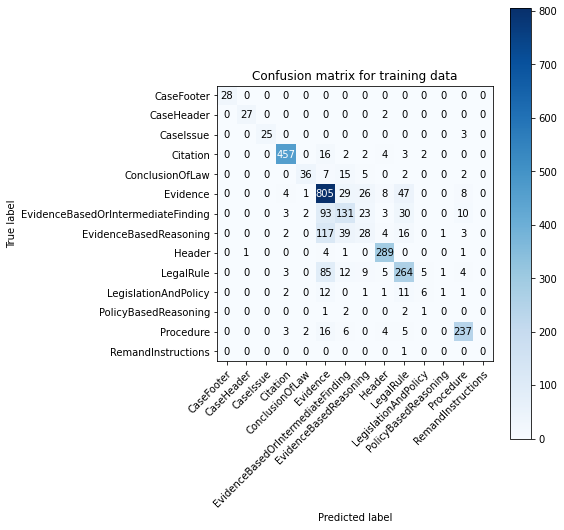

In [87]:
plot_confusion_matrix(test_spans_labels, clf.predict(test_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

In [88]:
type_names_by_id

{'61aeaf8097ad59b4cfc416d7': 'CaseFooter',
 '61aeaf8f97ad59b4cfc416d8': 'CaseHeader',
 '61aeaf9b97ad59b4cfc416d9': 'CaseIssue',
 '61aeafe297ad59b4cfc416da': 'Citation',
 '61aeafed97ad59b4cfc416db': 'ConclusionOfLaw',
 '61aeb00b97ad59b4cfc416dc': 'Evidence',
 '61aeb07c97ad59b4cfc416de': 'EvidenceBasedOrIntermediateFinding',
 '61aeb09097ad59b4cfc416df': 'EvidenceBasedReasoning',
 '61aeb0a497ad59b4cfc416e0': 'Header',
 '61aeb0d497ad59b4cfc416e1': 'LegislationAndPolicy',
 '61aeb19697ad59b4cfc416e3': 'Procedure',
 '61aeb1a297ad59b4cfc416e4': 'RemandInstructions',
 '61b20e3897ad59b4cfc41c04': 'LegalRule',
 '61b2315297ad59b4cfc42545': 'PolicyBasedReasoning'}

In [89]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [90]:
prediction_errors(clf,
                  random.sample(train_spans, 100),
                  spacy_tfidf_vectorizer,
                  select_pred_label='Evidence')

sentence # 3 / case 0715872.txt / @7413
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
The service medical records do not reveal any complaints of 
or treatment for tinnitus.

sentence # 16 / case 0606260.txt / @10730
pred: Evidence / true: Procedure
In 
rendering her opinion, Dr. LME had access to the C-file 
including the private and VA medical opinions and internet 
research conducted by the veteran.

sentence # 23 / case 1121621.txt / @11816
pred: Evidence / true: EvidenceBasedOrIntermediateFinding
Neither of these documents constitutes competent medical evidence of the cause of the Veteran's disability.

sentence # 32 / case 1231338.txt / @33664
pred: Evidence / true: EvidenceBasedReasoning
Such harassment is facially plausible.

sentence # 46 / case 1231338.txt / @30662
pred: Evidence / true: LegalRule
Noted means "[o]nly such conditions as are recorded in examination reports."

sentence # 62 / case 0724458.txt / @4658
pred: Evidence / true: EvidenceBasedReasoning
VA's